<a href="https://colab.research.google.com/github/heghiw/lakovaci-linka/blob/main/fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install pulp
import pandas as pd


import pandas as pd
import numpy as np
import pulp

In [47]:
# Remove the existing directory
!rm -rf lakovaci-linka

# Clone the repository again
!git clone https://github.com/heghiw/lakovaci-linka.git

# Navigate to the directory
%cd lakovaci-linka


Cloning into 'lakovaci-linka'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 116 (delta 51), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (116/116), 9.60 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/lakovaci-linka/lakovaci-linka/lakovaci-linka


data prep

In [48]:
# Define the path to the Excel file
file_path = '/content/lakovaci-linka/data1.xlsx'

# Read the sheet 'linka' into a DataFrame
linka_df = pd.read_excel(file_path, sheet_name='linka')

# Read the sheet 'recept' into a DataFrame
recept_df = pd.read_excel(file_path, sheet_name='recept')

print("Linka:")
print(linka_df)
print("\nRecepty:")
print(recept_df)

Linka:
             typ vany  id_vany   pozice_x_rel  pozice_x_cum
0               vstup         0           0.0           0.0
1        Teplý oplach         1        2300.0        2300.0
2             Postřik         2        1900.0        4200.0
3    Ponor odm železo         3        1900.0        6100.0
4    Ponor odm pozink         4        1800.0        7900.0
5            oplach 1         5        1800.0        9700.0
6            oplach 2         6        1800.0       11500.0
7       Moření železo         7        1800.0       13300.0
8       Moření pozink         8        1800.0       15100.0
9      Oplach moř žel         9        1800.0       16900.0
10  Oplach moř pozink        10        1800.0       18700.0
11    oplach společný        11        1800.0       20500.0
12           aktivace        12        1800.0       22300.0
13             fosfát        13        1800.0       24100.0
14             oplach        14        1800.0       25900.0
15            Oplach         21  

manipulator and vozik characteristics

In [49]:
manipulator_characteristics = {
        "okap_point": 2000,
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

In [50]:
linka_df.columns = linka_df.columns.str.strip()
recept_df.columns = recept_df.columns.str.strip()
print(linka_df.columns)
print(recept_df.columns)

Index(['typ vany', 'id_vany', 'pozice_x_rel', 'pozice_x_cum'], dtype='object')
Index(['tech', 'id_vany', 'poradi_operace', 'cas_min', 'cas_max', 'cas_opt',
       'okap', 'okap_cas'],
      dtype='object')


simulace


In [51]:
# ====================================================
# Helper Function: Get Optimal Dwell Time for a Bath
# ====================================================
def optimal_dwell_val(b, recipe_df):
    # Returns the "optimal" dwell time for bath b:
    # if okap == 1 then cas_opt + okap_cas, else cas_opt.
    row = recipe_df[recipe_df['id_vany'] == b]
    if row.empty:
        return None
    row = row.iloc[0]
    if row['okap'] == 1:
        return float(row['cas_opt']) + float(row['okap_cas'])
    else:
        return float(row['cas_opt'])

# ====================================================
# Stage 0: Common Helper Functions
# ====================================================
def m_per_sec(m_per_min):
    return m_per_min / 60.0

def compute_move_time(src, dst, linka_df, manip_char):
    pos_src = float(linka_df.loc[linka_df['id_vany'] == src, 'pozice_x_cum'].values[0])
    pos_dst = float(linka_df.loc[linka_df['id_vany'] == dst, 'pozice_x_cum'].values[0])
    speed_horiz = m_per_sec(manip_char["speed_left_right"])
    speed_up    = m_per_sec(manip_char["speed_going_up"])
    speed_down  = m_per_sec(manip_char["speed_going_down"])
    speed_near  = m_per_sec(manip_char["speed_after_ponoreni"])
    highest_m   = manip_char["highest_point"] / 1000.0
    decel_m     = manip_char["deceleration_point"] / 1000.0
    vertical_up   = highest_m / speed_up
    time_down1    = (highest_m - decel_m) / speed_down
    time_down2    = decel_m / speed_near
    vertical_down = time_down1 + time_down2
    dist_m = abs(pos_dst - pos_src) / 1000.0
    horiz_t = dist_m / speed_horiz
    return vertical_up + horiz_t + vertical_down

def build_forward_moves(recipe, linka_df, manip_char):
    tech_baths = recipe['id_vany'].tolist()
    forward_moves = []
    for i in range(len(tech_baths) - 1):
        src = tech_baths[i]
        dst = tech_baths[i+1]
        if src != dst:
            t_move = compute_move_time(src, dst, linka_df, manip_char)
            forward_moves.append({
                "src": src,
                "dst": dst,
                "t_move": t_move
            })
    if tech_baths[-1] not in (0, 100):
        forward_moves.append({
            "src": tech_baths[-1],
            "dst": 0,
            "t_move": compute_move_time(tech_baths[-1], 0, linka_df, manip_char)
        })
    return forward_moves

# ====================================================
# Stage 1: Corridor Segmentation with Fixed (Optimal) Dwell Times
# ====================================================
def optimize_corridors_fixed(recipe, forward_moves, manip_char, linka_df, num_manipulators):
    # Use the recipe's optimal dwell: dwell = cas_opt (+ okap_cas if okap==1)
    dwell_map_fixed = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        d = float(row['cas_opt'])
        if row['okap'] == 1:
            d += float(row['okap_cas'])
        dwell_map_fixed[b] = d

    N = len(forward_moves)
    t = [0]
    for move in forward_moves:
        t.append(move["t_move"] + dwell_map_fixed.get(move["dst"], 0.0))

    C = [0]
    for i in range(1, N+1):
        C.append(C[i-1] + t[i])

    R = {}
    for i in range(1, N+1):
        for j in range(i, N+1):
            if j == N:
                R[(i,j)] = 0
            else:
                last_bath = forward_moves[j-1]["dst"]
                first_bath = forward_moves[i-1]["src"]
                if last_bath not in (0, 100):
                    R[(i,j)] = compute_move_time(last_bath, first_bath, linka_df, manip_char)
                else:
                    R[(i,j)] = 0

    arcs = [(i, j) for i in range(1, N+1) for j in range(i+1, N+2)]
    arc_cost = {}
    for (i, j) in arcs:
        arc_cost[(i, j)] = (C[j-1] - C[i-1]) + R[(i, j-1)]

    M_value = C[N] + max(R.values())

    model = pulp.LpProblem("Corridor_Segmentation_Fixed", pulp.LpMinimize)
    X = pulp.LpVariable.dicts("X", arcs, 0, 1, pulp.LpBinary)
    Z = pulp.LpVariable("Z", lowBound=0, cat=pulp.LpContinuous)

    model += Z, "Minimize_max_corridor_cost"
    model += pulp.lpSum([X[(1,j)] for j in range(2, N+2)]) == 1, "Start_from_1"
    model += pulp.lpSum([X[(i, N+1)] for i in range(1, N+1)]) == 1, "End_at_Nplus1"
    for i in range(2, N+1):
        model += (pulp.lpSum([X[(k,i)] for k in range(1, i)]) ==
                  pulp.lpSum([X[(i,j)] for j in range(i+1, N+2)])), f"Flow_node_{i}"
    model += pulp.lpSum([X[(i,j)] for (i,j) in arcs]) == num_manipulators, "Total_corridors"
    for (i, j) in arcs:
        model += Z >= arc_cost[(i,j)] - M_value*(1 - X[(i,j)]), f"ArcCost_{i}_{j}"

    solver = pulp.PULP_CBC_CMD(msg=False)
    model.solve(solver)
    print("Stage 1 MILP Status:", pulp.LpStatus[model.status])
    print("Stage 1 Optimal max corridor cost (takt) = {:.2f} s".format(pulp.value(Z)))

    corridors = []
    current_node = 1
    while current_node < N+1:
        for j in range(current_node+1, N+2):
            if pulp.value(X[(current_node,j)]) > 0.5:
                corridors.append((current_node, j-1))
                current_node = j
                break

    corridor_info = []
    for (i, j) in corridors:
        cost = (C[j] - C[i-1]) + R[(i,j)]
        first_bath = forward_moves[i-1]["src"]
        last_bath  = forward_moves[j-1]["dst"]
        corridor_info.append({
            "Corridor": len(corridor_info),
            "Moves": (i, j),
            "Bath Range": [first_bath, last_bath],
            "Cycle Time (s)": round(cost, 2)
        })
    return corridor_info, dwell_map_fixed

# ====================================================
# Stage 2: Optimize Dwell Times via Unified Cost Function
# ====================================================
def optimize_dwell_times(corridor_info, forward_moves, recipe, linka_df, manip_char, num_manipulators, alpha=1, gamma=100):
    dwell_bounds = {}
    optimal_dwell = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        if b in (0, 100):
            continue
        lb = float(row['cas_min'])
        ub = float(row['cas_max'])
        if row['okap'] == 1:
            opt_val = float(row['cas_opt']) + float(row['okap_cas'])
        else:
            opt_val = float(row['cas_opt'])
        dwell_bounds[b] = (lb, ub)
        optimal_dwell[b] = opt_val

    unique_baths = set(move["dst"] for move in forward_moves)
    y = {}
    for b in unique_baths:
        if b in dwell_bounds:
            lb, ub = dwell_bounds[b]
            y[b] = pulp.LpVariable(f"y_{b}", lb, ub, cat=pulp.LpContinuous)

    N = len(forward_moves)
    corridor_cycle = []
    for idx, (i, j) in enumerate([info["Moves"] for info in corridor_info]):
        expr = 0
        for k in range(i, j+1):
            move = forward_moves[k-1]
            b = move["dst"]
            if b in y:
                expr += move["t_move"] + y[b]
            else:
                expr += move["t_move"]
        if forward_moves[j-1]["dst"] not in (0, 100):
            expr += compute_move_time(forward_moves[j-1]["dst"], forward_moves[i-1]["src"], linka_df, manip_char)
        corridor_cycle.append(expr)

    M = pulp.LpVariable("M", lowBound=0, cat=pulp.LpContinuous)
    for idx, cycle_expr in enumerate(corridor_cycle):
        pulp.LpConstraint(e= M - cycle_expr, sense=pulp.LpConstraintGE, rhs=0, name=f"Cycle_corridor_{idx}")
    v = pulp.LpVariable("v", lowBound=0, cat=pulp.LpContinuous)
    pulp.LpConstraint(e = v - (M - 300), sense=pulp.LpConstraintGE, rhs=0, name="Penalty_over_300")

    z = {}
    for b in y:
        z[b] = pulp.LpVariable(f"z_{b}", lowBound=0, cat=pulp.LpContinuous)

    dwell_model = pulp.LpProblem("Optimize_Dwell_Times", pulp.LpMinimize)
    dwell_model += alpha * pulp.lpSum([z[b] for b in z]) + gamma * v, "Total_Cost"

    for b in y:
        dwell_model += y[b] - optimal_dwell[b] <= z[b], f"Dev1_b{b}"
        dwell_model += optimal_dwell[b] - y[b] <= z[b], f"Dev2_b{b}"

    for idx, cycle_expr in enumerate(corridor_cycle):
        dwell_model += M >= cycle_expr, f"Cycle_corridor_{idx}"

    dwell_model += v >= M - 300, "Penalty_over_300"

    solver = pulp.PULP_CBC_CMD(msg=False)
    dwell_model.solve(solver)
    print("\nStage 2 MILP Status:", pulp.LpStatus[dwell_model.status])
    print("Optimized overall cycle time M = {:.2f} s".format(pulp.value(M)))
    print("Penalty v = {:.2f} s".format(pulp.value(v)))

    optimized_dwell = {b: pulp.value(y[b]) for b in y}

    optimized_corridor_info = []
    for idx, info in enumerate(corridor_info):
        i, j = info["Moves"]
        cycle_time = 0
        bath_seq = []
        for k in range(i, j+1):
            move = forward_moves[k-1]
            bath_seq.append(move["src"])
            b = move["dst"]
            d_val = optimized_dwell.get(b, 0)
            cycle_time += move["t_move"] + d_val
        bath_seq.append(forward_moves[j-1]["dst"])
        if forward_moves[j-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(forward_moves[j-1]["dst"], forward_moves[i-1]["src"], linka_df, manip_char)
            cycle_time += ret_time
        optimized_corridor_info.append({
            "Corridor": info["Corridor"],
            "Moves": info["Moves"],
            "Bath Sequence": bath_seq,
            "Optimized Cycle Time (s)": round(cycle_time, 2)
        })
    return optimized_dwell, optimized_corridor_info, pulp.value(M)

# ====================================================
# Simulation: Decoupled Dwell Scenario
# ====================================================
def simulate_pipeline_decoupled(opt_corridor_info, forward_moves, optimized_dwell, num_products, linka_df, manip_char):
    """
    For decoupled dwell, the manipulator’s active cycle time excludes dwell delays.
    The product’s readiness is delayed by the dwell times.
    """
    m = len(opt_corridor_info)
    cycle_no_dwell = []
    delays = []
    for info in opt_corridor_info:
        i_start, i_end = info["Moves"]
        moves = forward_moves[i_start-1 : i_end]
        move_sum = sum(move["t_move"] for move in moves)
        delay_sum = sum(optimized_dwell.get(move["dst"], 0) for move in moves)
        if moves[-1]["dst"] not in (0, 100):
            ret = compute_move_time(moves[-1]["dst"], moves[0]["src"], linka_df, manip_char)
        else:
            ret = 0
        cycle_no_dwell.append(move_sum + ret)
        delays.append(delay_sum)
    bottleneck = max(cycle_no_dwell)
    T_dec = np.zeros((num_products, m))
    F_dec = np.zeros((num_products, m))
    ready = np.zeros((num_products, m))
    for p in range(num_products):
        T_dec[p,0] = p * bottleneck
        F_dec[p,0] = T_dec[p,0] + cycle_no_dwell[0]
        ready[p,0] = F_dec[p,0] + delays[0]
    for i in range(1, m):
        T_dec[0,i] = ready[0,i-1]
        F_dec[0,i] = T_dec[0,i] + cycle_no_dwell[i]
        ready[0,i] = F_dec[0,i] + delays[i]
        for p in range(1, num_products):
            T_dec[p,i] = max(F_dec[p,i-1], F_dec[p-1,i])
            F_dec[p,i] = T_dec[p,i] + cycle_no_dwell[i]
            ready[p,i] = F_dec[p,i] + delays[i]
    events = []
    for i in range(m):
        for p in range(num_products):
            events.append({
                "Time (s)": T_dec[p,i],
                "Manipulator": i,
                "Action": f"Start Corridor {i} (active move: {cycle_no_dwell[i]:.2f} s)",
                "Product": p
            })
            events.append({
                "Time (s)": F_dec[p,i],
                "Manipulator": i,
                "Action": f"End Corridor {i}",
                "Product": p
            })
    events = sorted(events, key=lambda x: x["Time (s)"])
    sim_log = []
    for event in events:
        t_event = event["Time (s)"]
        prods_in = sum(T_dec[p,0] <= t_event for p in range(num_products))
        prods_out = sum(F_dec[p,m-1] <= t_event for p in range(num_products))
        sim_log.append({
            "Time (s)": round(t_event,2),
            "Manipulator": event["Manipulator"],
            "Action": event["Action"],
            "Product": event["Product"],
            "Products In": prods_in,
            "Products Out": prods_out
        })
    sim_log_df = pd.DataFrame(sim_log)
    return T_dec, F_dec, sim_log_df, cycle_no_dwell, delays

# ====================================================
# Detailed Move Sequence Table (Decoupled Dwell)
# ====================================================
def generate_detailed_move_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manip_char):
    """
    For each corridor, generate a table with columns:
    [StepIdx, From, To, StartTime (s), EndTime (s), MoveTime (s), Dwell (s), Manipulator, Product]
    where times are relative to the cycle start (product cycle = active moves + dwell delays).
    """
    rows = []
    # We'll assume Product = 0 for the cycle schedule.
    for info in opt_corridor_info:
        seg = info["Moves"]
        manip = info["Corridor"]
        moves = forward_moves[seg[0]-1 : seg[1]]  # 0-indexed list of moves for the corridor
        current_time = 0.0
        step_idx = 0
        # Process each move:
        for move in moves:
            start_time = current_time
            end_time = start_time + move["t_move"]
            dwell_time = optimized_dwell.get(move["dst"], 0)
            rows.append({
                "StepIdx": step_idx,
                "From": move["src"],
                "To": move["dst"],
                "StartTime (s)": round(start_time, 2),
                "EndTime (s)": round(end_time, 2),
                "MoveTime (s)": round(move["t_move"], 2),
                "Dwell (s)": round(dwell_time, 2),
                "Manipulator": manip,
                "Product": 0
            })
            current_time = end_time + dwell_time
            step_idx += 1
        # Add return move if needed:
        if moves[-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(moves[-1]["dst"], moves[0]["src"], linka_df, manip_char)
            start_time = current_time
            end_time = start_time + ret_time
            rows.append({
                "StepIdx": "Return",
                "From": moves[-1]["dst"],
                "To": moves[0]["src"],
                "StartTime (s)": round(start_time, 2),
                "EndTime (s)": round(end_time, 2),
                "MoveTime (s)": round(ret_time, 2),
                "Dwell (s)": 0,
                "Manipulator": manip,
                "Product": 0
            })
            current_time = end_time
        # print the final cycle time for the corridor.
        rows.append({
            "StepIdx": "CycleTime",
            "From": "",
            "To": "",
            "StartTime (s)": "",
            "EndTime (s)": "",
            "MoveTime (s)": round(current_time, 2),
            "Dwell (s)": "",
            "Manipulator": manip,
            "Product": 0
        })
    df = pd.DataFrame(rows)
    return df

# ====================================================
# Final Cycle Schedule Printout (Decoupled Version)
# ====================================================
def print_final_cycle_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manip_char):
    print("\n=== Final Program for Each Manipulator (Decoupled Dwell) ===")
    for info in opt_corridor_info:
        seg = info.get("Moves")
        bath_seq = info.get("Bath Sequence")
        manip = info["Corridor"]
        if bath_seq is None:
            seg = info["Moves"]
            bath_seq = [forward_moves[seg[0]-1]["src"]]
            for k in range(seg[0]-1, seg[1]):
                bath_seq.append(forward_moves[k]["dst"])
        # Calculate active move time
        move_sum = sum(forward_moves[k-1]["t_move"] for k in range(seg[0], seg[1]+1))
        if forward_moves[seg[1]-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(forward_moves[seg[1]-1]["dst"], forward_moves[seg[0]-1]["src"], linka_df, manip_char)
        else:
            ret_time = 0
        active_cycle = move_sum + ret_time
        delay_sum = sum(optimized_dwell.get(forward_moves[k-1]["dst"], 0) for k in range(seg[0], seg[1]+1))
        overall_cycle = active_cycle + delay_sum
        print(f"\nManipulator {manip}:")
        print(f"  Bath Sequence: {bath_seq}")
        print(f"  Active Cycle Time (manipulator moves): {active_cycle:.2f} s")
        print(f"  Total Product Dwell Delay: {delay_sum:.2f} s")
        print(f"  Overall Product Cycle Time: {overall_cycle:.2f} s")

# ====================================================
# Main Script
# ====================================================
if __name__ == "__main__":
    # ----- Provided Linka Data -----

    linka_df = linka_df[linka_df["pozice_x_rel"].notna()].copy()


    recept_df.sort_values("poradi_operace", inplace=True)

    # ----- Manipulator Characteristics -----
    manipulator_characteristics = {
        "okap_point": 2000,
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

    tech = "tech2"
    num_manipulators = 6

    # Filter recipe for chosen tech
    recipe = recept_df[recept_df['tech'] == tech].copy()
    if recipe.empty:
        raise ValueError(f"No recipe found for tech '{tech}'.")

    # ----- Stage 1: Fixed Segmentation Using Optimal Dwell Times -----
    forward_moves = build_forward_moves(recipe, linka_df, manipulator_characteristics)
    print("Forward moves (bath transitions):")
    for move in forward_moves:
        print(f"  {move['src']} -> {move['dst']} (move time: {move['t_move']:.2f} s)")

    corridor_info, dwell_map_fixed = optimize_corridors_fixed(recipe, forward_moves, manipulator_characteristics, linka_df, num_manipulators)
    print("\n=== Stage 1: Fixed Corridor Segmentation ===")
    for info in corridor_info:
        print(f"Manipulator {info['Corridor']}: Bath Range {info['Bath Range']}, Full Cycle Time = {info['Cycle Time (s)']} s")
    baseline_takt = max(info['Cycle Time (s)'] for info in corridor_info)
    print(f"\nBaseline Takt (with fixed dwell) = {baseline_takt:.2f} s")

    # ----- Stage 2: Optimize Dwell Times via Unified Cost Function -----
    alpha = 1
    gamma = 100
    optimized_dwell, opt_corridor_info, M_val = optimize_dwell_times(corridor_info, forward_moves, recipe, linka_df, manipulator_characteristics, num_manipulators, alpha, gamma)
    print("\n=== Stage 2: Optimized Dwell Times ===")
    print("Optimized dwell times (seconds):")
    for b in sorted(optimized_dwell.keys()):
        print(f"  Bath {b}: {optimized_dwell[b]:.2f} s (optimal = {optimal_dwell_val(b, recipe):.2f} s)")
    print("\nOptimized Corridor Cycle Times:")
    for info in opt_corridor_info:
        print(f"Manipulator {info['Corridor']}: Bath Sequence {info['Bath Sequence']}, Optimized Cycle Time = {info['Optimized Cycle Time (s)']} s")
    print(f"\nOptimized Overall Cycle Time M = {M_val:.2f} s")

    # ----- Simulation: Decoupled Dwell Scenario -----
    num_products = 10
    T_dec, F_dec, sim_log_dec, cycle_no_dwell, delays = simulate_pipeline_decoupled(opt_corridor_info, forward_moves, optimized_dwell, num_products, linka_df, manipulator_characteristics)
    print("\n=== Detailed Simulation Log (Decoupled Dwell) ===")
    print(sim_log_dec.to_string(index=False))

    # ----- Detailed Move Sequence Table -----
    move_schedule_df = generate_detailed_move_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manipulator_characteristics)
    print("\n=== Detailed Move Sequence for Each Manipulator (One Cycle) ===")
    print(move_schedule_df.to_string(index=False))

    # ----- Final Cycle Schedule (Decoupled Version) -----
    print_final_cycle_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manipulator_characteristics)




Forward moves (bath transitions):
  0 -> 1 (move time: 29.94 s)
  1 -> 2 (move time: 29.26 s)
  2 -> 3 (move time: 29.26 s)
  3 -> 5 (move time: 32.17 s)
  5 -> 6 (move time: 29.09 s)
  6 -> 11 (move time: 41.43 s)
  11 -> 12 (move time: 29.09 s)
  12 -> 13 (move time: 29.09 s)
  13 -> 14 (move time: 29.09 s)
  14 -> 21 (move time: 29.09 s)
  21 -> 15 (move time: 29.09 s)
  15 -> 16 (move time: 29.09 s)
  16 -> 17 (move time: 29.94 s)
  17 -> 18 (move time: 29.94 s)
  18 -> 19 (move time: 29.09 s)
  19 -> 20 (move time: 29.09 s)
  20 -> 100 (move time: 29.94 s)
Stage 1 MILP Status: Optimal
Stage 1 Optimal max corridor cost (takt) = 650.89 s

=== Stage 1: Fixed Corridor Segmentation ===
Manipulator 0: Bath Range [0, 2], Full Cycle Time = 392.4 s
Manipulator 1: Bath Range [2, 11], Full Cycle Time = 650.89 s
Manipulator 2: Bath Range [11, 13], Full Cycle Time = 620.34 s
Manipulator 3: Bath Range [13, 16], Full Cycle Time = 534.69 s
Manipulator 4: Bath Range [16, 19], Full Cycle Time = 547

In [52]:
def plot_detailed_move_schedule(df):
    """
    Given a move schedule DataFrame (from generate_detailed_move_schedule_decoupled),
    plot a Gantt-chart style diagram showing active move segments and dwell segments
    for each manipulator.
    """
    import matplotlib.pyplot as plt

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors: one for moves, one for dwell segments.
    move_color = 'skyblue'
    dwell_color = 'salmon'

    # We'll group the table by manipulator.
    grouped = df[df["StepIdx"] != "CycleTime"].groupby("Manipulator")

    for manip, group in grouped:
        # For each row in the group, plot the move and then the dwell (if dwell > 0)
        for idx, row in group.iterrows():
            start = row["StartTime (s)"]
            end = row["EndTime (s)"]
            # Compute the move duration and dwell duration from the table:
            move_duration = row["MoveTime (s)"]
            dwell_duration = row["Dwell (s)"]
            # Plot active move segment (from start to start+move_duration)
            ax.broken_barh([(start, move_duration)], (manip*10, 3), facecolors=move_color, edgecolor="black")
            # Label the move step (using the step index)
            ax.text(start + move_duration/2, manip*10 + 1.5, f"{row['StepIdx']}", ha="center", va="center", fontsize=8)
            # If there is a dwell period, plot that next to the move segment.
            if dwell_duration > 0:
                ax.broken_barh([(start+move_duration, dwell_duration)], (manip*10, 3), facecolors=dwell_color, edgecolor="black")
                ax.text(start+move_duration+dwell_duration/2, manip*10 + 1.5, "Dwell", ha="center", va="center", fontsize=8, color="black")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Manipulator")
    # Set y-ticks so that each manipulator is labeled
    num_manipulators = df["Manipulator"].max() + 1
    ax.set_yticks([i*10+1.5 for i in range(num_manipulators)])
    ax.set_yticklabels([f"Manipulator {i}" for i in range(num_manipulators)])
    ax.set_title("Detailed Move Schedule (One Cycle, Decoupled Dwell)")
    plt.tight_layout()
    plt.show()


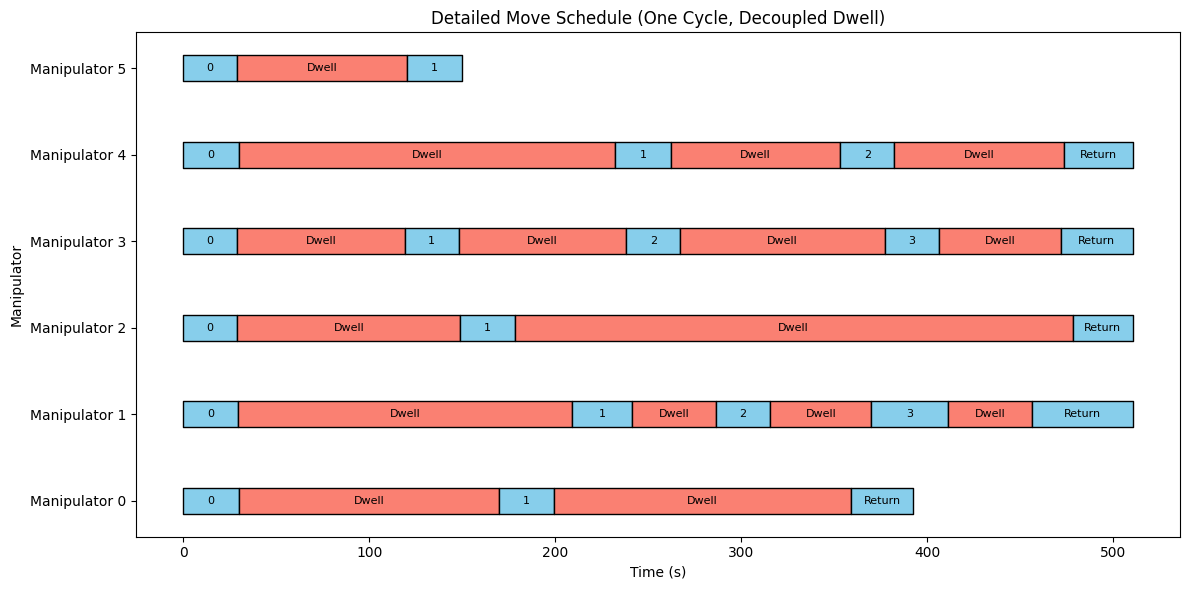

In [53]:
plot_detailed_move_schedule(move_schedule_df)


ver2